In [3]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import dlc_practical_prologue2 as prologue

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print('Libraries Imported')
print('Cuda Device Found? ', torch.cuda.is_available())
if torch.cuda.is_available == True:
    print('Type of Cuda Device:', torch.cuda.get_device_name(device))

Libraries Imported
Cuda Device Found?  False


To get the data for the first project, we are using one of the functions of *dlc_practical_prologe.py* that randomly generates one for us given a size parameter. It returns a tuple containing the: *training set, targets, classes* and *testing set, targets, classes*. 

In [4]:
sample_size = 1000
sets = prologue.generate_pair_sets(sample_size)

train_set = sets[0]
train_target = sets[1]
train_classes = sets[2]

test_set = sets[3]
test_target = sets[4]
test_classes = sets[5]

Put the data tensors to the CUDA device (if found).

In [5]:
train_set, test_set = train_set.to(device), test_set.to(device)
train_target, test_target = train_target.to(device), test_target.to(device)

print('Train Set in cuda device?', train_set.is_cuda)

Train Set in cuda device? False


The inputs are grayscale MNIST images consisting of two channels ($2 \times 14 \times 14$) representing two different digits. As visualized below, target vector contains the index of the channels which have the highest digit between the two (channel $0$ or $1$). 

Therefore, our task is to maximize the prediction of this boolean value.

For the first training data point with two channels, target is 0


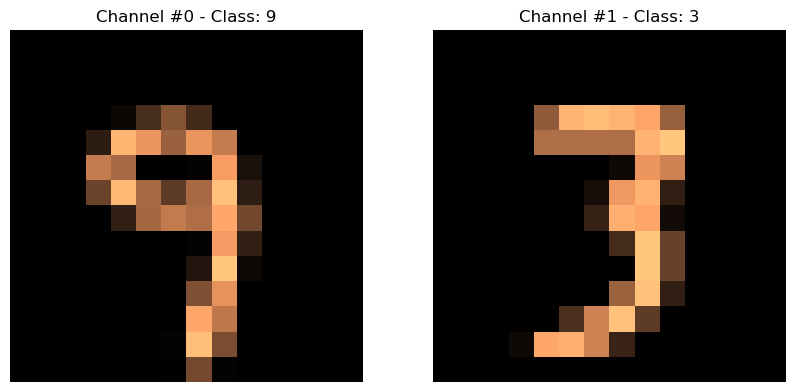

In [6]:
print('For the first training data point with two channels, target is {}'.format(train_target[0]))
fig1, axes = plt.subplots(1, 2, figsize = (10, 7))
ax = axes.ravel()

for i in range(len(ax)):
    ax[i].set_title('Channel #{} - Class: {}'.format(i, train_classes[0][i]))
    ax[i].imshow(train_set[0][i], cmap='copper')
    ax[i].axis('off')
plt.show()

Function to train the model by moving it through the given mini batch size and using Adam as an optimizer.

In [7]:
def train_model(n_epochs, eta, gamma, loss_criterion, model, train_input, train_target, train_classes, mini_batch_size):
    aux_loss_criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.01, lr = eta)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 5)
    for _ in range(n_epochs):
        acc_loss = 0 ## set error as 0 each iteration
        ## Using mini-batches
        for b in range(0, train_input.size(0), mini_batch_size): 
            # output = model(train_input.narrow(0, b, mini_batch_size))
            
            model.zero_grad() ## setting the gradients to zero before the loss calculation
            output = model(train_input.narrow(0, b, mini_batch_size))
            # output, output_aux = model(train_input.narrow(0, b, mini_batch_size))
            # print('Loss Shapes: Output: {}, Target: {}'.format(output.shape, train_target.narrow(0, b, mini_batch_size).shape))
            loss1 = loss_criterion(output, train_target.narrow(0, b, mini_batch_size).float())
            # print('Aux Shapes: ', output_aux.shape, train_classes.narrow(0, b, mini_batch_size).shape)
            # print('Output', output_aux)
            # print('True', train_classes.narrow(0, b, mini_batch_size))
            # print(train_classes.narrow(0, b, mini_batch_size))
            # aux_loss = aux_loss_criterion(output_aux, train_classes.narrow(0, b, mini_batch_size))
            # print('loss', aux_loss)
            # loss = loss1 + (gamma * aux_loss)
            
            loss = loss1
            acc_loss = acc_loss + loss.item()
            loss.backward()
            optimizer.step()
            # optimizer.zero_grad()
        scheduler.step()
    # print('Final Output: ', output, output.shape)
    # print(torch.argmax(output, dim=1))
    # print('Model Training Finished - Final loss after {} epochs: {}'.format(n_epochs, acc_loss))

Round the final values outputted from the network into binary values and compare them with the target binary matrix in order to get the number of errors.

The sigmoid function $\sigma(x) = \frac 1 {1+exp(-x)}$ is applied to the output to distribute the output values between $0$ and $1$, after which a rounding process happens to finally compare them with our binary targets. 

In [8]:
def compute_nb_errors(model, input, target, mini_batch_size):
    nb_errors = 0
    with torch.no_grad():
        for b in range(0, input.size(0), mini_batch_size):
            # output, _ = model(input.narrow(0, b, mini_batch_size))
            # output_sigmoid = torch.sigmoid(output)
            # errors = torch.where(torch.round(output_sigmoid) != target.narrow(0, b, mini_batch_size))
            
            ### When we apply sigmoid inside the model
            output = model(input.narrow(0, b, mini_batch_size))
            output_sigmoid = torch.sigmoid(output)
            # print('final output', output)
            errors = torch.where(torch.round(output_sigmoid) != target.narrow(0, b, mini_batch_size))

            ## Errors return a tuple with the first element being a tensor with indexes
            ## Where the targets and predictions dont match
            ## Therefore we get the size of this tensor as a number of errors
            nb_errors += errors[0].size(0) 
    return nb_errors

##### Defining both models

The first model will be a classical Binary Convolutional Network Classifier inspired by LeNet, that takes the number of the hidden layers of the final fully connected layer as a parameter. 
As seen from the results below, it suffers from overfitting at the moment therefore it should be modified (dropout to be added next).

The second model will be a Multi-Layer Perceptron with only linear hidden layers, constructed in order to compare the difference between this and the convolutional network, measuring the overfitting too. 

They both includes multiple dropout layers with respective rates of $0.4$ and share a weight decay parameter on the Adam Optimizer, as measures to combat overfitting.

Trying out the BinaryCNN however splitting the 2 image channels and passing them one by one.

In [9]:
class BinaryCNN(nn.Module):
    def __init__(self, dropout_rate): ## defining the layers
        super().__init__()
        self.dropoutfc = nn.Dropout(p = dropout_rate)
        self.dropoutcnn = nn.Dropout(0.0)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.flatten0 = nn.Flatten(0)
        self.flatten1 = nn.Flatten(1)
        
        # Feature Extractors & Data Normalizers 
        self.conv1 = nn.Conv2d(1, 64, kernel_size = 3, stride = 1)
        self.conv1_bn = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1)
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_bn = nn.BatchNorm2d(256)
        
        # Classifiers & Output Layers
        self.fc1 = nn.Linear(256, 10)
        
    ## Generally, strides for convolution layers are 1 and for maxpools are 2
    def forward(self, x): 
        ## Feature Extractors        
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.dropoutcnn(x)    
        # print('First Conv Layer Shape', x.shape)
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.dropoutcnn(x)    
        # print('Second Conv Layer Shape', x.shape)
        x = F.max_pool2d(F.relu(self.conv3_bn(self.conv3(x))), kernel_size= 2, stride = 2, dilation = (1, 1))
        x = self.dropoutcnn(x)
        # print('Third Conv Layer Shape', x.shape)
        
        ## Classifiers
        x = self.flatten1(x)
        # print('After Flattening', x.shape)
        x = self.dropoutfc(x)
        x = self.fc1(x)
        # x = F.relu(self.fc1(x))
        # x = self.batchnormfc1(x)
        # print('First Connected Layer: {} \n'.format(x.shape))
        x = self.flatten0(x)
        # print(y)
        # print('after softmax', y)
        # print('Final Output Shape {} \n'.format(x.shape))
        # print('Output', x)
        return x

In [10]:
class BinaryCNNSharing(nn.Module):
    def __init__(self, dropout_rate): ## defining the layers
        super().__init__()
        self.dropoutfc = nn.Dropout(p = dropout_rate)
        self.flatten0 = nn.Flatten(0)
        self.flatten1 = nn.Flatten(1)
        
        # Feature Extractors & Data Normalizers 
        self.sharedConvNet = BinaryCNN(dropout_rate=0.0)
        
        # Classifiers & Output Layers
        self.fc1 = nn.Linear(20, 1)
        # self.fc1_bn = nn.BatchNorm1d(1)
        # self.fc2 = nn.Linear(100, 1)
        # self.fc2_bn = nn.BatchNorm1d()
        
    ## Generally, strides for convolution layers are 1 and for maxpools are 2
    def forward(self, x): 
        ## Feature Extractors
        # We split the input in 2 separate set of images
        img1 = x.narrow(1, 0, 1)
        img2 = x.narrow(1, 1, 1)
        
        out1 = self.sharedConvNet(img1)
        out1 = out1.view(out1.size(-1) // 10, 10)
        # print('output 1 shape', out1.shape, out1)
        
        out2 = self.sharedConvNet(img2)
        out2 = out2.view(out2.size(-1) // 10, 10)
        # print('output 2 shape', out2.shape, out2)
        
        x = torch.cat((out1, out2), 1)
        # print('kh kh', x.shape)
        x = self.dropoutfc(x)
        x = self.fc1(x)
        # x = torch.sigmoid(x)
        # x = torch.max(x, 1)[0]
        x = self.flatten0(x)
        # print('yo yo', x)
        
        ## Classifiers
        # x = self.flatten1(x)
        # # print('After Flattening', x.shape)
        # x = self.dropoutfc(x)
        # x = self.fc1(x)
        # # x = F.relu(self.fc1(x))
        # # x = self.batchnormfc1(x)
        # # print('First Connected Layer: {} \n'.format(x.shape))
        # x = self.flatten0(x)
        # # print(y)
        # # print('after softmax', y)
        # print('Final Output Shape {} \n'.format(x.shape))
        # print('Output', x)
        return x

Training cell for one model, to be easily switched between MLP and CNN. Check the corresponding *.py* files to inspect the full models.

Hyperparameters after benchmarking (average over 10 runs): $40$ - $50$ batch size seems to be the best, $0.001$ or $0.0001$ weight decay, $10-25$ epochs sufficient 

In [11]:
from MLP_model import MLP
from CNN_first_model import BinaryCNNLegacy
from CNN_model_aux import BinaryCNNAux

print('models imported')

models imported


In [15]:
binary_criterion = nn.BCEWithLogitsLoss()
cross_entropy = nn.BCELoss()
eta = 0.001
mini_batch_size = 50
nb_epochs = 5
n_runs = 10
epochs = [1, 5, 10, 15, 25, 40, 50]
aux_gammas = [0.00]
one_hot_classes = F.one_hot(train_classes, num_classes = 10).view(-1, 20).float()
t_maxes = [1, 3, 5, 7, 10, 12, 15, 20]

# for e in epochs:
avg_error_train = []
avg_error_test = []
for i in range(n_runs):
    # model = BinaryCNNLegacy(dropout_rate=0.0)
    model = BinaryCNNSharing(dropout_rate = 0.0)
    
    model.to(device) ### Putting model to cuda device or cpu is there is no cuda device
    model.train()
    train_model(25, eta, 0.0, binary_criterion, model, train_set, train_target, one_hot_classes, mini_batch_size)
    
    model.eval()    
    error_train = compute_nb_errors(model, train_set, train_target.to(torch.float32), mini_batch_size)
    avg_error_train.append(error_train / train_set.size(0))
    error_test = compute_nb_errors(model, test_set, test_target.to(torch.float32), mini_batch_size)
    avg_error_test.append(error_test / train_set.size(0))

print('Classification Error on the training set with {} epochs - Average: {:.2f}%'.format('', (sum(avg_error_train) / n_runs) * 100))
print('Classification Error on the testing set with {} epochs - Average: {:.2f}%, Minimum: {}%, SD: {:.2f}'.format(
    '', 
    (sum(avg_error_test) / n_runs) * 100, 
    min(avg_error_test) * 100, 
    torch.std(torch.Tensor(avg_error_test))
    ))           
print('')

Classification Error on the training set with  epochs - Average: 0.00%
Classification Error on the testing set with  epochs - Average: 13.92%, Minimum: 13.0%, SD: 0.01



Training cell for both models to calculate their performance on the testing set and to be used for benchmarking & fine-tuning with different hyperparameters.

In [19]:
## Shared parameters to both models
binary_criterion = nn.BCEWithLogitsLoss()
mini_batch_size = 50
nb_epochs = 25
n_runs = 10
eta = 0.001
aux_gamma = 0.0

# Lists for Plotting & Benchmarks Purposes
# all_epochs = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]
all_epochs = [i + 1 for i in range(50)]
all_errors_cnn_train = []
all_errors_mlp_train = []
all_errors_cnn = []
all_errors_mlp = []
test_sd_cnn = []
test_sd_mlp = []
test_max_cnn = []
test_max_mlp = []
test_min_cnn = []
test_min_mlp = []


for e in range(len(all_epochs)):
    avg_error_train_cnn = []
    avg_error_test_cnn = []
    avg_error_train_mlp = []
    avg_error_test_mlp = []
    print('Average over {} Epochs'.format(all_epochs[e]))
    for i in range(n_runs):   
        conv_model = BinaryCNNSharing(dropout_rate = 0.0)
        mlp_model = BinaryCNNLegacy(dropout_rate = 0.2)
        
        ## Training CNN
        train_model(all_epochs[e], eta, aux_gamma, binary_criterion, conv_model, train_set, train_target.to(torch.float32), train_classes, mini_batch_size)
        ## Training MLP
        train_model(all_epochs[e], eta, aux_gamma, binary_criterion, mlp_model, train_set, train_target.to(torch.float32), train_classes, mini_batch_size)
            
        conv_model.eval()
        conv_errors_train = compute_nb_errors(conv_model, train_set, train_target.to(torch.float32), mini_batch_size)
        conv_errors_test = compute_nb_errors(conv_model, test_set, test_target.to(torch.float32), mini_batch_size)
        avg_error_train_cnn.append(conv_errors_train / train_set.size(0))
        avg_error_test_cnn.append(conv_errors_test / test_set.size(0))
        
        mlp_model.eval()
        mlp_errors_train = compute_nb_errors(mlp_model, train_set, train_target.to(torch.float32), mini_batch_size)
        mlp_errors_test = compute_nb_errors(mlp_model, test_set, test_target.to(torch.float32), mini_batch_size)
        avg_error_train_mlp.append(mlp_errors_train / train_set.size(0))
        avg_error_test_mlp.append(mlp_errors_test / test_set.size(0))

    all_errors_cnn_train.append(sum(avg_error_train_cnn) / n_runs)
    all_errors_cnn.append(sum(avg_error_test_cnn) / n_runs)
    test_sd_cnn.append(torch.std(torch.Tensor(avg_error_test_cnn)))
    test_min_cnn.append(min(avg_error_test_cnn))
    test_max_cnn.append(max(avg_error_test_cnn))
    
    all_errors_mlp_train.append(sum(avg_error_train_mlp) / n_runs)
    all_errors_mlp.append(sum(avg_error_test_mlp) / n_runs)
    test_sd_mlp.append(torch.std(torch.Tensor(avg_error_test_mlp)))
    test_min_mlp.append(min(avg_error_test_mlp))
    test_max_mlp.append(max(avg_error_test_mlp))


    print('First CNN - Classification Error on the training set: Average: {:.2f}%, Minimum: {:.2f}%'.format((all_errors_mlp_train[e] * 100), (min(avg_error_train_mlp) * 100)))
    print('First CNN - Classification Error on the testing set: Average: {:.2f}%, Minimum: {:.2f}%'.format((all_errors_mlp[e] * 100), (min(avg_error_test_mlp) * 100)))
    print('CNN (Weight Sharing) - Classification Error on the training set: Average: {:.2f}%, Minimum: {:.2f}%'.format((all_errors_cnn_train[e] * 100), (min(avg_error_train_cnn) * 100)))
    print('CNN (Weight Sharing) - Classification Error on the testing set: Average: {:.2f}%, Minimum: {:.2f}%\n'.format((all_errors_cnn[e] * 100), (min(avg_error_test_cnn) * 100)))

Average over 1 Epochs
First CNN - Classification Error on the training set: Average: 24.16%, Minimum: 19.50%
First CNN - Classification Error on the testing set: Average: 27.30%, Minimum: 23.10%
CNN (Weight Sharing) - Classification Error on the training set: Average: 14.15%, Minimum: 12.70%
CNN (Weight Sharing) - Classification Error on the testing set: Average: 17.38%, Minimum: 16.00%

Average over 2 Epochs
First CNN - Classification Error on the training set: Average: 14.87%, Minimum: 6.00%
First CNN - Classification Error on the testing set: Average: 23.19%, Minimum: 18.50%
CNN (Weight Sharing) - Classification Error on the training set: Average: 8.15%, Minimum: 7.50%
CNN (Weight Sharing) - Classification Error on the testing set: Average: 14.37%, Minimum: 13.80%

Average over 3 Epochs
First CNN - Classification Error on the training set: Average: 5.55%, Minimum: 1.50%
First CNN - Classification Error on the testing set: Average: 19.65%, Minimum: 16.70%
CNN (Weight Sharing) - Class

As we can view from the plot below, the overfitting on the testing set persists no matter the number of epochs.

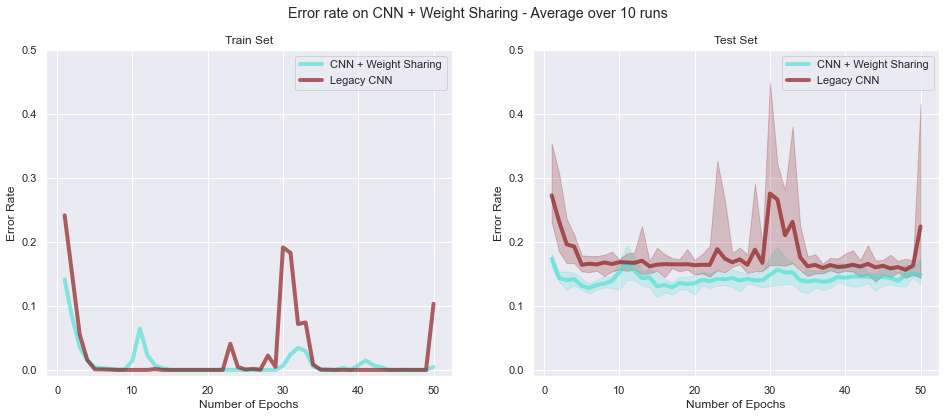

In [55]:
import seaborn as sns
sns.set()

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Error rate on CNN + Weight Sharing - Average over 10 runs')
axs[0].set_title("Train Set")
axs[0].plot(all_epochs, all_errors_cnn_train, alpha=0.6, linewidth=4, color='turquoise', label='CNN + Weight Sharing')
axs[0].plot(all_epochs, all_errors_mlp_train, alpha=0.6, linewidth=4, color='maroon', label='Legacy CNN')
axs[0].legend(loc='upper right')

axs[1].set
axs[1].set_title("Test Set")
axs[1].plot(all_epochs, all_errors_cnn, alpha=0.6, linewidth=4, color='turquoise', label='CNN + Weight Sharing')
axs[1].plot(all_epochs, all_errors_mlp, alpha=0.6, linewidth=4, color='maroon', label='Legacy CNN')
axs[1].fill_between(all_epochs, test_max_cnn, test_min_cnn, color='turquoise', alpha = 0.2)
axs[1].fill_between(all_epochs, test_max_mlp, test_min_mlp, color='maroon', alpha = 0.2)
axs[1].legend(loc='upper right')

for ax in axs.flat:
    ax.set(xlabel='Number of Epochs', ylabel='Error Rate', ylim=(-0.01, 0.5))
plt.show()